In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# research question 1: How did the Tiananmen Square incident impact the frequency of neoliberal terms in the People's Daily discourse?"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
file_path = '/content/drive/My Drive/PreprocessedTexts.csv'

df = pd.read_csv(file_path, encoding='utf-8-sig')

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])
print("DataFrame reloaded successfully.")

DataFrame reloaded successfully.


In [10]:
import pandas as pd
import jieba

# List of neoliberal terms in Chinese
neoliberal_terms = ['新自由主义', '市场', '放松管制', '私有化', '自由化', '小康社会', '消费主义', '自由市场', '自由贸易', '金融市场', '自由化', '全球化', '私有化', "经济改革", "市场化"]  # Update this list as needed

# Function to tokenize Chinese text and count occurrences of neoliberal terms
def count_neoliberal_terms(text):
    tokens = jieba.lcut(text)
    return sum(tokens.count(term) for term in neoliberal_terms)

df['preprocessed_text'] = df['preprocessed_text'].fillna('')

# Then apply the count_neoliberal_terms function
df['terms_count'] = df['preprocessed_text'].apply(count_neoliberal_terms)

# Check if the new column has been added successfully
print(df.head())


        date                             title  \
0 1985-01-01                和衷共济搞四化——一九八五年元旦献词   
1 1985-01-01                     一九八五年一月上旬天气展望   
2 1985-01-01                     血液换出稀释法可治疗脑血栓   
3 1985-01-01  玻利维亚紧张局势得到缓和  拒绝交权的前陆军司令奥尔维斯被迫投降   
4 1985-01-01                     北京假肢科研所主体工程奠基   

                                                text  \
0      和衷共济搞四化\n    ——一九八五年元旦献词\n    岁月之树又增添了一周新的...   
1      一九八五年一月上旬天气展望\n    据新华社北京12月31日电　中央气象台对198...   
2      血液换出稀释法可治疗脑血栓\n    山东省济宁市第二人民医院用血液换出稀释法治疗脑...   
3      玻利维亚紧张局势得到缓和\n    拒绝交权的前陆军司令奥尔维斯被迫投降\n    ...   
4      北京假肢科研所主体工程奠基\n    本报讯  民政部北京假肢科研主体工程12月31...   

                                   preprocessed_text  post_treatment  period1  \
0          和衷共济 搞 四化 \n         一九八五年 元旦 献词 \n   ...               0        1   
1          一九八五年 一月 上旬 天气 展望 \n         新华社 北京 12...               0        1   
2          血液 换 出 稀释 法可 治疗 脑血栓 \n         山东省 济宁市...               0        1   
3          玻利维亚 紧张局势 得到 缓和 \n         

In [11]:
import statsmodels.formula.api as smf

# Define the treatment variable based on a specific date (e.g., the Tiananmen Square incident date)
df['post_treatment'] = (df['date'] > '1989-06-04').astype(int)

# Replace 'other_control_variables' with actual control variables relevant to your analysis
formula = 'terms_count ~ post_treatment'

# Fit the model
model = smf.ols(formula=formula, data=df).fit()

# Print the summary of the regression model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            terms_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     463.5
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          9.49e-103
Time:                        05:03:45   Log-Likelihood:            -7.6369e+05
No. Observations:              375302   AIC:                         1.527e+06
Df Residuals:                  375300   BIC:                         1.527e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2432      0.005     50.

In [12]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [14]:
df['article_length'] = df['preprocessed_text'].apply(len)

Adding article length as confound variable

In [16]:
formula = 'terms_count ~ post_treatment + article_length'

# Running the DiD model
model = smf.ols(formula, data=df).fit(cov_type='HC0')  # HC0 for robust standard errors

# Output the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            terms_count   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     402.9
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          1.61e-175
Time:                        05:25:24   Log-Likelihood:            -7.4449e+05
No. Observations:              375302   AIC:                         1.489e+06
Df Residuals:                  375299   BIC:                         1.489e+06
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.2330      0.024     -9.

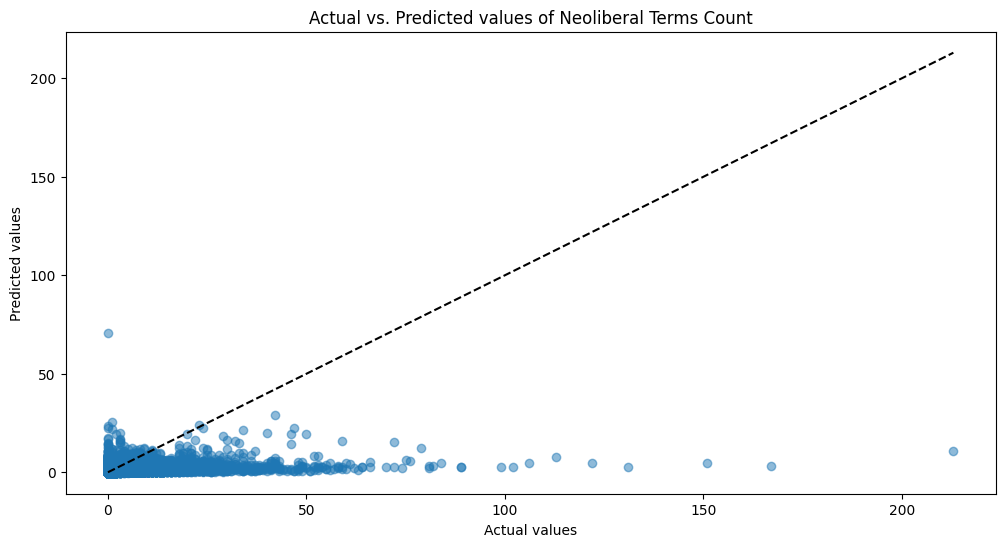

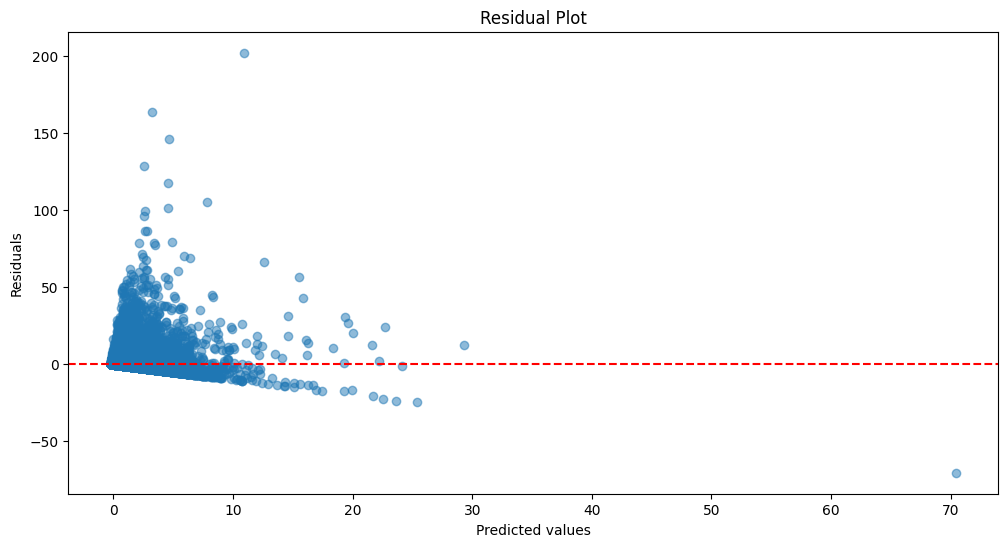

In [17]:
# Calculate predicted values
df['predicted'] = model.fittedvalues

# Plot actual vs predicted values of terms_count
plt.figure(figsize=(12, 6))
plt.scatter(df['terms_count'], df['predicted'], alpha=0.5)
plt.plot([df['terms_count'].min(), df['terms_count'].max()], [df['terms_count'].min(), df['terms_count'].max()], '--k')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs. Predicted values of Neoliberal Terms Count')
plt.show()

# Residual plot
plt.figure(figsize=(12, 6))
plt.scatter(df['predicted'], model.resid, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
